In [1]:
%matplotlib inline

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)
print(halocat.halo_table.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['halo_vmax_firstacc', 'halo_dmvir_dt_tdyn', 'halo_macc', 'halo_scale_factor', 'halo_vmax_mpeak', 'halo_m_pe_behroozi', 'halo_delta_vmax_behroozi17', 'halo_xoff', 'halo_spin', 'halo_tidal_force', 'halo_scale_factor_firstacc', 'halo_c_to_a', 'halo_mvir_firstacc', 'halo_scale_factor_last_mm', 'halo_tidal_id', 'halo_scale_factor_mpeak', 'halo_pid', 'halo_m500c', 'halo_id', 'halo_halfmass_scale_factor', 'halo_upid', 'halo_t_by_u', 'halo_rvir', 'halo_vpeak', 'halo_dmvir_dt_100myr', 'halo_mpeak', 'halo_m_pe_diemer', 'halo_jx', 'halo_jy', 'halo_jz', 'halo_m2500c', 'halo_mvir', 'halo_voff', 'halo_axisA_z', 'halo_axisA_x', 'halo_axisA_y', 'halo_y', 'halo_b_to_a', 'halo_x', 'halo_z', 'halo_m200b', 'halo_vacc', 'halo_scale_factor_lastacc', 'halo_vmax', 'halo_m200c', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_dmvir_dt_inst', 'halo_tidal_force_tdyn', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo']


## Calculate host-centric distance

In [4]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(halocat.halo_table['halo_hostid'], halocat.halo_table['halo_id'])

halocat.halo_table['rvir_host_halo'] = halocat.halo_table['halo_rvir']
halocat.halo_table['halo_x_host_halo'] = halocat.halo_table['halo_x']
halocat.halo_table['halo_y_host_halo'] = halocat.halo_table['halo_y']
halocat.halo_table['halo_z_host_halo'] = halocat.halo_table['halo_z']
halocat.halo_table['halo_vx_host_halo'] = halocat.halo_table['halo_vx']
halocat.halo_table['halo_vy_host_halo'] = halocat.halo_table['halo_vy']
halocat.halo_table['halo_vz_host_halo'] = halocat.halo_table['halo_vz']

halocat.halo_table['rvir_host_halo'][idxA] = halocat.halo_table['halo_rvir'][idxB]

halocat.halo_table['halo_x_host_halo'][idxA] = halocat.halo_table['halo_x'][idxB]
halocat.halo_table['halo_y_host_halo'][idxA] = halocat.halo_table['halo_y'][idxB]
halocat.halo_table['halo_z_host_halo'][idxA] = halocat.halo_table['halo_z'][idxB]
halocat.halo_table['halo_vx_host_halo'][idxA] = halocat.halo_table['halo_vx'][idxB]
halocat.halo_table['halo_vy_host_halo'][idxA] = halocat.halo_table['halo_vy'][idxB]
halocat.halo_table['halo_vz_host_halo'][idxA] = halocat.halo_table['halo_vz'][idxB]

In [5]:
from halotools.mock_observables import radial_distance_and_velocity

xs = halocat.halo_table['halo_x']
ys = halocat.halo_table['halo_y']
zs = halocat.halo_table['halo_z']
vxs = halocat.halo_table['halo_vx']
vys = halocat.halo_table['halo_vy']
vzs = halocat.halo_table['halo_vz']

xc = halocat.halo_table['halo_x_host_halo']
yc = halocat.halo_table['halo_y_host_halo']
zc = halocat.halo_table['halo_z_host_halo']
vxc = halocat.halo_table['halo_vx_host_halo']
vyc = halocat.halo_table['halo_vy_host_halo']
vzc = halocat.halo_table['halo_vz_host_halo']

drad, vrad = radial_distance_and_velocity(xs, ys, zs, vxs, vys, vzs, 
                                          xc, yc, zc, vxc, vyc, vzc, halocat.Lbox)
halocat.halo_table['host_centric_distance'] = drad
halocat.halo_table['r_by_rvir'] = drad/halocat.halo_table['rvir_host_halo']



Fix edge case where no host halo was found

In [6]:
badsat_mask = (halocat.halo_table['r_by_rvir']==0) & (halocat.halo_table['halo_upid']!=-1)
num_missing_hosts = np.count_nonzero(badsat_mask)
halocat.halo_table['r_by_rvir'][badsat_mask] = np.random.uniform(0, 1, num_missing_hosts)
halocat.halo_table['host_centric_distance'][badsat_mask] = (
    halocat.halo_table['r_by_rvir'][badsat_mask]*
    halocat.halo_table['rvir_host_halo'][badsat_mask])

## Assign $M_{\ast}$ using Behroozi+10 model for $\langle M_{\ast}\vert M_{\rm peak}\rangle$  

In [7]:
from halotools.empirical_models import Behroozi10SmHm
mstar_model = Behroozi10SmHm(redshift=0)

halocat.halo_table['mstar'] = mstar_model.mc_stellar_mass(
    prim_haloprop=halocat.halo_table['halo_mpeak'])

## Assign quenching using $\langle F_{\rm q}\ |\ M_{\rm vir}\rangle_{\rm cens}$ & $\langle F_{\rm q}\ |\ M_{\rm host}\rangle_{\rm sats}$  from Zu & Mandelbaum  

In [8]:
from halotools.empirical_models import ZuMandelbaum16QuenchingCens
quenching_model_cens = ZuMandelbaum16QuenchingCens()

halocat.halo_table['is_quenched'] = False
cenmask = halocat.halo_table['halo_upid']==-1
halocat.halo_table['is_quenched'][cenmask] = quenching_model_cens.mc_quiescent(
    prim_haloprop=halocat.halo_table['halo_mvir'][cenmask])

from halotools.empirical_models import ZuMandelbaum16QuenchingSats
quenching_model_sats = ZuMandelbaum16QuenchingSats()

halocat.halo_table['is_quenched'][~cenmask] = quenching_model_sats.mc_quiescent(
    prim_haloprop=halocat.halo_table['halo_mvir_host_halo'][~cenmask])

## Calculate ${\rm Prob(<r/R_{vir}\ \vert\ M_{\rm host})}$ for  satellites

In [9]:
from halotools.utils import sliding_conditional_percentile

halocat.halo_table['radial_distribution_cdf'] = 0.

x = halocat.halo_table['halo_mvir_host_halo'][~cenmask]
y = halocat.halo_table['r_by_rvir'][~cenmask]
window = 1001
cdf = sliding_conditional_percentile(x, y, window)
halocat.halo_table['radial_distribution_cdf'][~cenmask] = cdf

## Use ${\rm Prob(<r/R_{vir}\ \vert\ M_{\rm host})}$ as input to satellite quenching Monte Carlo

In [10]:
from scipy.stats import uniform

mean_fq_sats = quenching_model_sats.mean_quiescent_fraction(
    prim_haloprop=halocat.halo_table['halo_mvir_host_halo'][~cenmask])
uran = halocat.halo_table['radial_distribution_cdf'][~cenmask]
sat_is_quenched2 = uniform.isf(1-uran) < mean_fq_sats
halocat.halo_table['is_quenched_model2'] = halocat.halo_table['is_quenched']
halocat.halo_table['is_quenched_model2'][~cenmask] = sat_is_quenched2


# Add noise to create a new model with stochasticity in the correlation between $r/R_{\rm vir}$ and quenching

In [11]:
from halotools.empirical_models import noisy_percentile
p = halocat.halo_table['radial_distribution_cdf'][~cenmask]
correlation_coeff = 0.5
noisy_uran = noisy_percentile(p, correlation_coeff)
sat_is_quenched3 = uniform.isf(1-noisy_uran) < mean_fq_sats
halocat.halo_table['is_quenched_model3'] = halocat.halo_table['is_quenched']
halocat.halo_table['is_quenched_model3'][~cenmask] = sat_is_quenched3

In [12]:
sats = halocat.halo_table[~cenmask]

Now we compare histograms of the radial distributions of quenched and star-forming satellites. First we look at Model 1, where we just randomly assigned quenching without any explicit regard for host-centric position. 


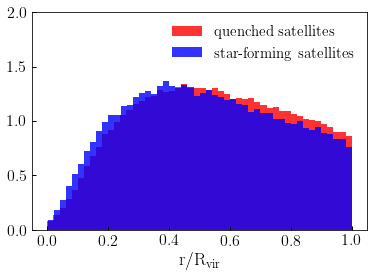

In [13]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(sats['r_by_rvir'][sats['is_quenched']], 
           bins=50, alpha=0.8, color='red', normed=True, 
          label=r'${\rm quenched\ satellites}$')
__=ax.hist(sats['r_by_rvir'][~sats['is_quenched']], 
           bins=50, alpha=0.8, color='blue', normed=True, 
          label=r'${\rm star}$-${\rm forming\ satellites}$')

xlabel = ax.set_xlabel(r'${\rm r / R_{vir}}$')
legend = ax.legend()
ylim = ax.set_ylim(0, 2)

There is actually a mild inverted gradient that can be seen in this plot, such that blue satellites are slightly more radially concentrated than red satellites. This asymmetry is inherited by the radial distributions of subhalos, which are more concentrated in lower-mass host halos where the quenched fraction is smaller, which is the origin of the mild inverted gradient. 

We can confirm that this is what is going on by looking directly at the radial distributions of subhalos in large- and small-mass host halos. 

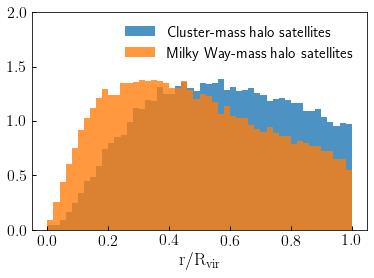

In [14]:
fig, ax = plt.subplots(1, 1)

large_host_mass_mask = sats['halo_mvir_host_halo'] > 10**14
small_host_mass_mask = sats['halo_mvir_host_halo'] < 10**12.25

__=ax.hist(sats['r_by_rvir'][large_host_mass_mask], bins=50, alpha=0.8, 
        normed=True, label=r'Cluster-mass halo satellites')
__=ax.hist(sats['r_by_rvir'][small_host_mass_mask], bins=50, alpha=0.8, 
           normed=True, label=r'Milky Way-mass halo satellites')

legend = ax.legend()

ylim = ax.set_ylim(0, 2.)
xlabel = ax.set_xlabel(r'${\rm r / R_{vir}}$')

Now we'll look at the radial distributions predicted by the CAM models. 

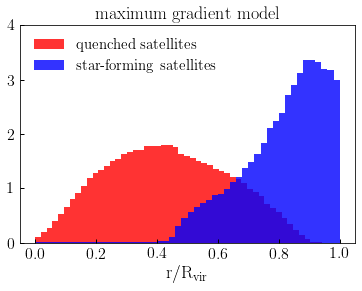

In [15]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(sats['r_by_rvir'][sats['is_quenched_model2']], 
           bins=50, alpha=0.8, color='red', normed=True, 
          label=r'${\rm quenched\ satellites}$')
__=ax.hist(sats['r_by_rvir'][~sats['is_quenched_model2']], 
           bins=50, alpha=0.8, color='blue', normed=True, 
          label=r'${\rm star}$-${\rm forming\ satellites}$')

legend = ax.legend()

ylim = ax.set_ylim(0, 4.)
xlabel = ax.set_xlabel(r'${\rm r / R_{vir}}$')
title = ax.set_title(r'${\rm maximum\ gradient\ model}$')

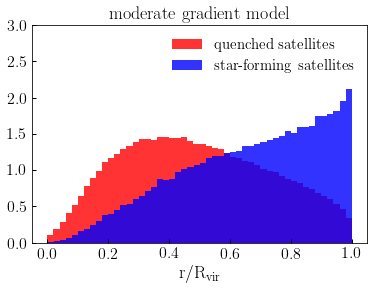

In [16]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(sats['r_by_rvir'][sats['is_quenched_model3']], 
           bins=50, alpha=0.8, color='red', normed=True, 
          label=r'${\rm quenched\ satellites}$')
__=ax.hist(sats['r_by_rvir'][~sats['is_quenched_model3']], 
           bins=50, alpha=0.8, color='blue', normed=True, 
          label=r'${\rm star}$-${\rm forming\ satellites}$')

legend = ax.legend()

ylim = ax.set_ylim(0, 3)
xlabel = ax.set_xlabel(r'${\rm r / R_{vir}}$')
title = ax.set_title(r'${\rm moderate\ gradient\ model}$')

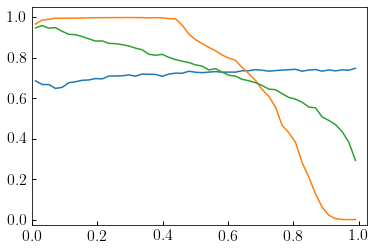

In [17]:
from scipy.stats import binned_statistic

r_by_rvir_bins = np.linspace(0, 1, 50)
r_by_rvir_mids = 0.5*(r_by_rvir_bins[:-1]+r_by_rvir_bins[1:])
quenching_gradient1, __, __ = binned_statistic(sats['r_by_rvir'], sats['is_quenched'], 
                                             bins=r_by_rvir_bins, statistic='mean')
quenching_gradient2, __, __ = binned_statistic(sats['r_by_rvir'], sats['is_quenched_model2'], 
                                             bins=r_by_rvir_bins, statistic='mean')
quenching_gradient3, __, __ = binned_statistic(sats['r_by_rvir'], sats['is_quenched_model3'], 
                                             bins=r_by_rvir_bins, statistic='mean')
fig, ax = plt.subplots(1, 1)

__=ax.plot(r_by_rvir_mids, quenching_gradient1)
__=ax.plot(r_by_rvir_mids, quenching_gradient2)
__=ax.plot(r_by_rvir_mids, quenching_gradient3)

xlim = ax.set_xlim(0., 1.025)
ylim = ax.set_ylim(-0.025, 1.05)

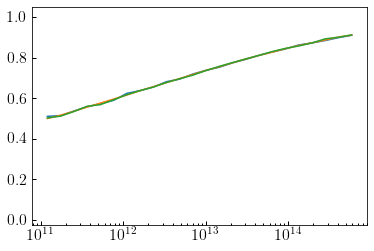

In [18]:
from scipy.stats import binned_statistic

log_mhost_bins = np.linspace(11, 14.85, 25)
mhost_bins = 10**log_mhost_bins
mhost_mids = 10**(0.5*(log_mhost_bins[:-1]+log_mhost_bins[1:]))

quiescent_fraction1, __, __ = binned_statistic(sats['halo_mvir_host_halo'], 
                                               sats['is_quenched'], 
                                             bins=mhost_bins, statistic='mean')
quiescent_fraction2, __, __ = binned_statistic(sats['halo_mvir_host_halo'], 
                                               sats['is_quenched_model2'], 
                                             bins=mhost_bins, statistic='mean')
quiescent_fraction3, __, __ = binned_statistic(sats['halo_mvir_host_halo'], 
                                               sats['is_quenched_model3'], 
                                             bins=mhost_bins, statistic='mean')

fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

__=ax.plot(mhost_mids, quiescent_fraction1)
__=ax.plot(mhost_mids, quiescent_fraction2)
__=ax.plot(mhost_mids, quiescent_fraction3)

ylim = ax.set_ylim(-0.025, 1.05)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0)  #  smash left and right plots

__=ax1.plot(r_by_rvir_mids, quenching_gradient2, label=r'${\rm max\ gradient}$')
__=ax1.plot(r_by_rvir_mids, quenching_gradient3, label=r'${\rm moderate\ gradient}$')
__=ax1.plot(r_by_rvir_mids, quenching_gradient1, label=r'${\rm mild\ inverted\ gradient}$')
# __=ax1.plot(r_by_rvir_mids, quenching_gradient4, label=r'$z_{\rm infall}\ {\rm gradient}$')


xlim1 = ax1.set_xlim(0., 1)
ylim1 = ax1.set_ylim(-0.025, 1.05)
xlabel1 = ax1.set_xlabel(r'$r/R_{\rm vir}$')
ylabel1 = ax1.set_ylabel(r'$\langle F_{\rm quenched}\ \vert\ {\rm r/R_{vir}}\rangle$')
ylabel2 = ax2.set_ylabel(r'$\langle F_{\rm quenched}\ \vert\ M_{\rm host} \rangle$', rotation=-90, labelpad=25)
ax2.yaxis.set_label_position("right")  #  y-labels on the right
ax2.yaxis.tick_right()  #  y-ticks on the right

xscale2 = ax2.set_xscale('log')
xlabel2 = ax2.set_xlabel(r'$M_{\rm host}$')
ylim2 = ax2.set_ylim(-0.025, 1.05)
xlim2 = ax2.set_xlim(10**11.5, 10**14.75)


__=ax2.plot(mhost_mids, quiescent_fraction2, label=r'${\rm max\ gradient}$')
__=ax2.plot(mhost_mids, quiescent_fraction3, label=r'${\rm moderate\ gradient}$')
__=ax2.plot(mhost_mids, quiescent_fraction1, label=r'${\rm mild\ inverted\ gradient}$')
# __=ax2.plot(mhost_mids, quiescent_fraction4, label=r'$z_{\rm infall}\ {\rm gradient}$')

legend1 = ax1.legend()
legend2 = ax2.legend()

title1 = ax1.set_title(r'${\rm intra}$-${\rm halo\ quenching\ gradients}$')
title2 = ax2.set_title(r'${\rm halo\ mass\ quenching}$')

figname = 'quenching_gradient_models.png'
fig.savefig(figname, bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')

# Compute 3d clustering $\xi(r)$

In [20]:
mock_mask = halocat.halo_table['mstar'] > 10**9.5
mock = halocat.halo_table[mock_mask]

In [21]:
from halotools.mock_observables import tpcf, return_xyz_formatted_array

pos_all = return_xyz_formatted_array(
    mock['halo_x'], mock['halo_y'], mock['halo_z'])

pos_quenched_model1 = return_xyz_formatted_array(
    mock['halo_x'], mock['halo_y'], mock['halo_z'], 
    mask=mock['is_quenched'])

pos_active_model1 = return_xyz_formatted_array(
    mock['halo_x'], mock['halo_y'], mock['halo_z'], 
    mask=~mock['is_quenched'])

pos_quenched_model2 = return_xyz_formatted_array(
    mock['halo_x'], mock['halo_y'], mock['halo_z'], 
    mask=mock['is_quenched_model2'])

pos_active_model2 = return_xyz_formatted_array(
    mock['halo_x'], mock['halo_y'], mock['halo_z'], 
    mask=~mock['is_quenched_model2'])

pos_quenched_model3 = return_xyz_formatted_array(
    mock['halo_x'], mock['halo_y'], mock['halo_z'], 
    mask=mock['is_quenched_model3'])

pos_active_model3 = return_xyz_formatted_array(
    mock['halo_x'], mock['halo_y'], mock['halo_z'], 
    mask=~mock['is_quenched_model3'])

In [22]:
rbins = np.logspace(-1, 1.2, 25)
rmids = 10**(0.5*(np.log10(rbins[:-1])+np.log10(rbins[1:])))

xi_all = tpcf(pos_all, rbins, period=250.)


In [23]:
xi_quenched_model1 = tpcf(pos_quenched_model1, rbins, period=250.)
xi_quenched_model2 = tpcf(pos_quenched_model2, rbins, period=250.)
xi_quenched_model3 = tpcf(pos_quenched_model3, rbins, period=250.)


In [24]:
xi_active_model1 = tpcf(pos_active_model1, rbins, period=250.)
xi_active_model2 = tpcf(pos_active_model2, rbins, period=250.)
xi_active_model3 = tpcf(pos_active_model3, rbins, period=250.)


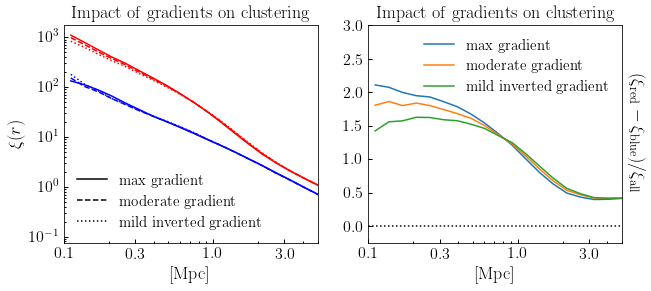

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))

__=ax1.loglog()

__=ax1.plot(rmids, xi_quenched_model2, color='red', 
            label=r'${\rm max\ gradient}$')
__=ax1.plot(rmids, xi_active_model2, color='blue')

__=ax1.plot(rmids, xi_quenched_model3, '--', color='red', 
            label=r'${\rm moderate\ gradient}$')
__=ax1.plot(rmids, xi_active_model3, '--', color='blue')

__=ax1.plot(rmids, xi_quenched_model1, ':', color='red', 
            label=r'${\rm mild\ inverted\ gradient}$')
__=ax1.plot(rmids, xi_active_model1, ':', color='blue')

xi_ratio_model1 = (xi_quenched_model1-xi_active_model1)/xi_all
xi_ratio_model2 = (xi_quenched_model2-xi_active_model2)/xi_all
xi_ratio_model3 = (xi_quenched_model3-xi_active_model3)/xi_all

xscale2 = ax2.set_xscale('log')
__=ax2.plot(rmids, xi_ratio_model2, label=r'${\rm max\ gradient}$')
__=ax2.plot(rmids, xi_ratio_model3, label=r'${\rm moderate\ gradient}$')
__=ax2.plot(rmids, xi_ratio_model1, label=r'${\rm mild\ inverted\ gradient}$')

__=ax2.plot(np.logspace(-3, 3, 100), np.zeros(100), ':', color='k')


ylim2 = ax2.set_ylim(-0.25, 3)

from matplotlib import ticker
xlim1 = ax1.set_xlim(0.1, 5)
xlim2 = ax2.set_xlim(0.1, 5)
xticks1 = ax1.set_xticks((0.1, 0.3, 1, 3))
xticks2 = ax2.set_xticks((0.1, 0.3, 1, 3))
yticks2 = ax2.set_yticks((0., 0.5, 1, 1.5, 2, 2.5, 3))
__=ax1.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())

xlabel1 = ax1.set_xlabel(r'${\rm\ [Mpc]}$')
xlabel2 = ax2.set_xlabel(r'${\rm\ [Mpc]}$')

ylabel1 = ax1.set_ylabel(r'$\xi(r)$')
ylabel2 = ax2.set_ylabel(r'$(\xi_{\rm red} - \xi_{\rm blue})/\xi_{\rm all}$', 
                        rotation=-90, labelpad=22)
ax2.yaxis.set_label_position("right")  

legend1 = ax1.legend()
legend1.legendHandles[0].set_color('k')
legend1.legendHandles[1].set_color('k')
legend1.legendHandles[2].set_color('k')
legend2 = ax2.legend()

title1 = ax1.set_title(r'${\rm Impact\ of\ gradients\ on\ clustering}$')
title2 = ax2.set_title(r'${\rm Impact\ of\ gradients\ on\ clustering}$')

figname = 'quenching_gradient_model_clustering.png'
fig.savefig(figname, bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')